# Objective
- base model without oversampling and feature selection & fine tune it
- base model with oversampling and feature selection & fine tune it

In [ ]:
import warnings

import pandas as pd
from numpy import arange
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.feature_selection import chi2,SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, KFold
import models.uci_heart_disease_dataset as uci

warnings.filterwarnings("ignore")

In [ ]:
# Load the preprocessed dataset (299 records; with 14 features).
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

In [ ]:
# Dictionary for storing executed model accuracies for result comparisons.
accuracies = {}

# Set the randomness for reproducing same split for comparisons.
random_state = 1

# Dictionary to hold hyperparameters for grid search.
parameters = dict()
parameters['kernel'] = ['rbf', 'poly', 'linear', 'sigmoid']
# Tried even with 30 - takes longer but still chooses 1.
parameters['C'] = arange(1, 10, 1)
parameters['gamma'] = ['scale', 'auto']
parameters['class_weight'] = ['dict', 'balanced']

# A stratified K fold for cross validation strategy.
skfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)

# A function to display classification-report, confusion-matrix and ROC curve for model result analysis.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def display_validation_report(y_test, y_pred, x_test, classifier, test_name):
    # Manually calculate accuracy in % for storing result.
    svc_acc=round(accuracy_score(y_test, y_pred)*100,2)
    accuracies[test_name] = svc_acc

    # Display the classification report.
    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

    # Display the confusion matrix.
    print("\nConfusion Matrix")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, linewidths=.5, square=True, cmap='Blues', cbar=False)
    plt.ylabel('Truth');
    plt.xlabel('Predicted')

    # Display ROC Curve.
    RocCurveDisplay.from_estimator(estimator=classifier,
                                   X=x_test,
                                   y=y_test);

def scale_and_split(x_set, y_set):
    # SVM is very slow with unscaled/normalized data.
    scaler = StandardScaler()
    x_set = scaler.fit_transform(x_set)

    # Do the train and test splits.
    # random-state for reproducing the same result. Also, stratify class.
    return train_test_split(x_set, y_set, test_size = 0.20, stratify=y, random_state=random_state)

In [ ]:
# A function to build base model.
# Acknowledgement: Code was referenced from Prof. Mafas Raheem's AML lab-8.
def build_and_validate_base_model(x_set, y_set, test_name, verbose=False):
    # Scale and do train/test split.
    x_train, x_test, y_train, y_test = scale_and_split(x_set, y_set)

    # Train the model with training set.
    svc= SVC(verbose=verbose)
    svc.fit(x_train, y_train)

    # Do prediction with the train model.
    y_pred = svc.predict(x_test)

    # Display classification-report, confusion-matrix and ROC curve
    display_validation_report(y_test, y_pred, x_test, svc, test_name)

In [ ]:
# A function to build and fine tune model using GridSearchCV.
def build_and_validate_with_grid_search_cv(x_set, y_set, test_name, parameters, validation_fold, verbose=False):
    # Scale and do train/test split.
    x_train, x_test, y_train, y_test = scale_and_split(x_set, y_set)

    grid_svc= SVC(verbose=verbose)

    ## Building Grid Search algorithm with cross-validation and acc score.
    grid_search_svc = GridSearchCV(grid_svc, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    grid_search_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params :{grid_search_svc.best_params_}.')
    print(f'Best score  :{grid_search_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = grid_search_svc.predict(x_test)

    # Display classification-report, confusion-matrix and ROC curve
    display_validation_report(y_test, y_pred, x_test, grid_search_svc, test_name)

In [ ]:
# A function to build and fine tune model using RandomSearchCV.
def fine_tuned_model_with_random_search_cv(x_set, y_set):
    scaler = StandardScaler()
    x_set = scaler.fit_transform(x_set)
    x_train, x_test, y_train, y_test = train_test_split(x_set, y_set, test_size = 0.20, random_state=0)

    rand_svc= SVC()

    parameters = dict()
    parameters['kernel'] = ['rbf', 'poly', 'linear', 'sigmoid']
    parameters['C'] = arange(1, 10, 1)
    parameters['gamma'] = ['scale', 'auto']
    parameters['class_weight'] = ['dict', 'balanced']

    ## Building Grid Search algorithm with cross-validation and acc score.

    k = StratifiedKFold(shuffle=True, random_state=0)

    rand_search_svc = RandomizedSearchCV(rand_svc, parameters, scoring='accuracy', cv=k)

    rand_search_svc.fit(x_train,y_train)
    best_parameters_svc = rand_search_svc.best_params_
    best_score_svc = rand_search_svc.best_score_
    print(best_parameters_svc)
    print(best_score_svc)

    y_pred = rand_search_svc.predict(x_test)

    # Get the accuracy score
    svc_acc=accuracy_score(y_test, y_pred)*100
    svc_pre=precision_score(y_test, y_pred, average='micro')
    svc_recall=recall_score(y_test, y_pred, average='micro')
    svc_f1_=f1_score(y_test, y_pred, average='micro')

    print("\nSVM - Accuracy: {:.3f}.".format(svc_acc))
    print("SVM - Precision: {:.3f}.".format(svc_pre))
    print("SVM - Recall: {:.3f}.".format(svc_recall))
    print("SVM - F1_Score: {:.3f}.".format(svc_f1_))
    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

### Standard Data (without over-sampling or feature selection)

In [28]:
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]


Test name: svm-baseline.

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.82      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


Confusion Matrix


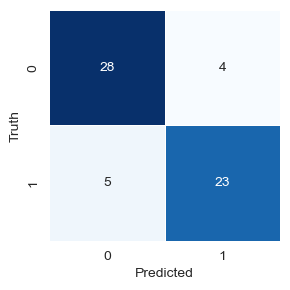

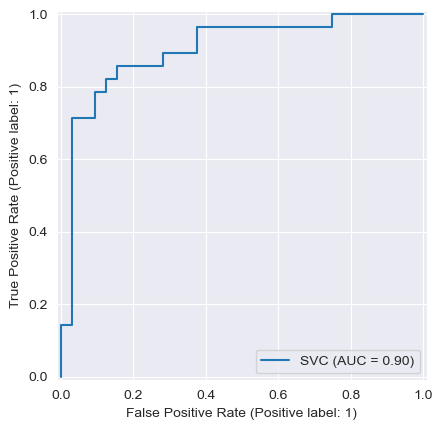

In [29]:
test_name = 'svm-baseline'
print(f'\nTest name: {test_name}.')
build_and_validate_base_model(X, y,test_name, verbose=False)


Test name: svm-grid.
Best params :{'C': 2, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}.
Best score  :0.8286347517730498.

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


Confusion Matrix


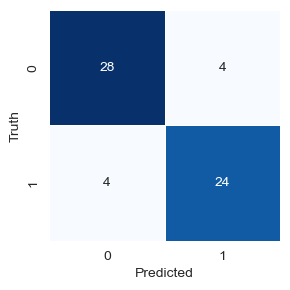

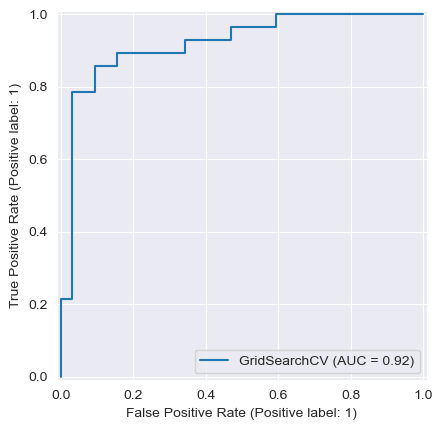

In [30]:
test_name = 'svm-grid'
print(f'\nTest name: {test_name}.')
build_and_validate_with_grid_search_cv(X, y,test_name, parameters, validation_fold=5, verbose=False)

In [31]:
print(accuracies)

{'svm-baseline': 85.0, 'svm-grid': 86.67}


### Data with over-sampling and feature selection

In [ ]:
chi_squared = SelectKBest(score_func=chi2, k=13)
chi_squared.fit(X, y)
feature_score = pd.DataFrame({"Score":chi_squared.scores_, "P_Value":np.round(chi_squared.pvalues_,3)}, index=X.columns)
feature_score.nlargest(n=13,columns="Score")

In [ ]:
chi_squared = SelectKBest(score_func=chi2, k=9)
X_fs = chi_squared.fit_transform(X, y)

In [ ]:
X_b, y_b = SMOTE().fit_resample(X_fs, y)
X_b.shape

build_and_validate_base_model(X_b, y_b)

In [ ]:
fine_tuned_model_with_random_search_cv(X_b, y_b)

In [ ]:
build_and_validate_with_grid_search_cv(X_b, y_b)